# Experimentation with Non-DL SVM

In [119]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from modules.data_loader import load_initial_data
from modules.text_segmentation import tokenize_text, handle_unusual_sentences
from modules.text_normalization import normalize_text
from modules.connlu_converter import convert_to_connlu
from modules.utils import setup_logging
import logging
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import joblib

## Load and Preprocess Data (Milestone 1)

In [2]:
# Setup logging
setup_logging()
logger = logging.getLogger(__name__)

# Define paths
if '__file__' in globals():
    base_path = os.path.dirname(os.path.abspath(__file__))
else:
    base_path = os.getcwd()
documents_path = os.path.join(base_path, "../training_data_16_October_release/EN/raw-documents")
annotations_file = os.path.join(base_path, "../training_data_16_October_release/EN/subtask-2-annotations.txt")
output_dir = os.path.join(base_path, "../CoNLL")
model_path = os.path.join(base_path, "./models/svm_model.joblib")


# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)


# 1. Load and prepare initial data
logger.info("Loading initial data...")
df = load_initial_data(documents_path, annotations_file)
logger.info(f"Loaded {len(df)} documents")

# 2. Tokenize text
logger.info("Tokenizing text...")
df = tokenize_text(df)

# 3. Handle unusual sentences
logger.info("Handling unusual sentences...")
df = handle_unusual_sentences(df)

# 4. Normalize text
logger.info("Normalizing text...")
df, df_ua, df_cc = normalize_text(df)
# print(df.head())
# print(df.columns)
# print(type(df['tokens_normalized'].iloc[0]))
# print(df['tokens_normalized'].iloc[0])
# print(df['narrative_subnarrative_pairs'].iloc[0])
# 5. Convert to CoNLL-U format
# only use when ConLL-U format is needed
#logger.info("Converting to CoNLL-U format...")
#convert_to_connlu(df, output_dir, 'tokens')
logger.info("Preprocessing completed successfully")

2024-12-15 11:14:24,694 - __main__ - INFO - Loading initial data...
2024-12-15 11:14:24,877 - __main__ - INFO - Loaded 198 documents
2024-12-15 11:14:24,893 - __main__ - INFO - Tokenizing text...
2024-12-15 11:14:26,893 - __main__ - INFO - Handling unusual sentences...
2024-12-15 11:14:26,893 - __main__ - INFO - Normalizing text...
2024-12-15 11:14:26,898 - modules.text_normalization - INFO - Using device: cpu


2024-12-15 11:14:26 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| lemma     | combined_nocharlm |



2024-12-15 11:14:26,931 - stanza - INFO - Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| lemma     | combined_nocharlm |



2024-12-15 11:14:26 INFO: Using device: cpu


2024-12-15 11:14:26,935 - stanza - INFO - Using device: cpu


2024-12-15 11:14:26 INFO: Loading: tokenize


2024-12-15 11:14:26,935 - stanza - INFO - Loading: tokenize


2024-12-15 11:14:26 INFO: Loading: lemma


2024-12-15 11:14:26,943 - stanza - INFO - Loading: lemma


c:\Users\nikla\AppData\Local\Programs\Python\Python312\Lib\site-packages\stanza\models\lemma\trainer.py:239: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch

2024-12-15 11:14:33,581 - stanza - INFO - Done loading processors!
2024-12-15 11:14:33,625 - modules.text_normalization - INFO - Starting processing of 198 rows in 4 batches


Normalizing text: 100%|██████████| 4/4 [00:21<00:00,  5.44s/it]

2024-12-15 11:14:55,400 - __main__ - INFO - Preprocessing completed successfully


In [3]:
print(df_ua.shape, df_cc.shape, df.shape)

(126, 6) (72, 6) (198, 6)


In [5]:
def create_label_mapping(all_narratives):
    """
    Create a consistent mapping for all narrative pairs
    
    Args:
        all_narratives: List of lists of narrative dictionaries
    
    Returns:
        dict: Mapping from narrative string to numeric index
    """
    unique_narratives = set()
    for narratives in all_narratives:
        for narrative in narratives:
            narrative_str = str(narrative)  # Convert dict to string
            unique_narratives.add(narrative_str)
    
    # Create mapping
    narrative_to_idx = {
        narrative: idx 
        for idx, narrative in enumerate(sorted(unique_narratives))
    }
    
    logger.info(f"Created mapping for {len(narrative_to_idx)} unique narratives")
    return narrative_to_idx

def get_first_narrative_label(narrative_list, label_mapping):
    """
    Convert first narrative in list to numeric label
    
    Args:
        narrative_list: List of narrative dictionaries
        label_mapping: Dictionary mapping narrative strings to indices
    
    Returns:
        int: Numeric label for the first narrative
    """
    if narrative_list and len(narrative_list) > 0:
        narrative_str = str(narrative_list[0])
        return label_mapping[narrative_str]
    return None

def prepare_data(df, label_mapping=None):
    """
    Prepare data for BERT training
    
    Args:
        df: DataFrame containing tokens_normalized and narrative_subnarrative_pairs
        label_mapping: Optional pre-existing label mapping to use
    
    Returns:
        tuple: (texts, labels, label_mapping)
    """
    try:
        # Handle tokens_normalized
        texts = df['tokens_normalized'].tolist()
        texts = [' '.join(tokens) if isinstance(tokens, list) else tokens for tokens in texts]
        
        # Convert narrative_subnarrative_pairs to list if it's a string
        narratives = df['narrative_subnarrative_pairs'].apply(
            lambda x: eval(x) if isinstance(x, str) else x
        ).tolist()

        # Create or use label mapping
        if label_mapping is None:
            label_mapping = create_label_mapping(narratives)
            
        # Convert narratives to binary indicator format for multilabel classification
        n_classes = len(label_mapping)
        labels = []
        for narrative_list in narratives:
            label_vector = [0] * n_classes
            for narrative in narrative_list:
                narrative_str = str(narrative)  # Convert narrative dict to string
                if narrative_str in label_mapping:
                    label_vector[label_mapping[narrative_str]] = 1
                else:
                    raise ValueError(f"Unknown narrative: {narrative_str}")
            labels.append(label_vector)

        logger.info(f"Number of unique labels in mapping: {len(label_mapping)}")
        logger.info(f"Sample text: {texts[0][:100]}")
        logger.info(f"Sample label: {labels[0]}")
        
        return texts, labels, label_mapping

    except Exception as e:
        logger.error(f"Error in prepare_data: {str(e)}")
        logger.error(f"Sample narrative_subnarrative_pairs: {df['narrative_subnarrative_pairs'].iloc[0]}")
        raise

def compute_metrics(pred):
    """
    Compute evaluation metrics
    
    Args:
        pred: Prediction object from trainer
    
    Returns:
        dict: Dictionary containing computed metrics
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="micro")
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## Support Vector Machine

### Training

We vectorize the data with TF-IDF and train a SVM model.


In [131]:


def train_svm(df, base_path, project_name="svm-training"):
    """
    Train an SVM model for multiclass multilabel classification.
    
    Args:
        df: DataFrame containing the training data.
        base_path: Base path for saving model outputs.
        project_name: Name for the project (for logging, optional).
    
    Returns:
        dict: Classification report.
    """
    try:
        # Create label mapping
        all_narratives = df['narrative_subnarrative_pairs'].apply(
            lambda x: eval(x) if isinstance(x, str) else x
        ).tolist()
        label_mapping = create_label_mapping(all_narratives)

        # Prepare data
        texts, labels, label_mapping = prepare_data(df, label_mapping)
        
        # Split the data into training and testing sets
        X_train_texts, X_test_texts, y_train, y_test = train_test_split(
            texts, labels, test_size=0.2, random_state=1,
        )
        
        # Vectorize text using TF-IDF
        vectorizer = TfidfVectorizer(max_features=5000)
        X_train = vectorizer.fit_transform(X_train_texts)
        X_test = vectorizer.transform(X_test_texts)
        
        # Train SVM using OneVsRestClassifier
        model = OneVsRestClassifier(LinearSVC())
        model.fit(X_train, y_train)

        # Save model
        joblib.dump(model, model_path)
        
        logger.info(f"Model saved to {model_path}")

        # Evaluate model
        y_pred = model.predict(X_test)

        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        logger.info("Training classification report:")
        logger.info(json.dumps(report, indent=2))

        # -------- Test 1: Table of Class Occurences in Train, Test and Predictions --------------

        flat_narratives = [item for sublist in df['narrative_subnarrative_pairs'] for item in sublist]        
        flat_labels = []
        for narrative in flat_narratives:
            narrative_str = str(narrative)
            flat_labels.append(label_mapping[narrative_str])
        onehot = pd.get_dummies(pd.Series(flat_labels)).to_numpy()
        onehot = (onehot > 0).astype(int)

        counts_original = pd.DataFrame(onehot).sum(axis=0).to_numpy()
        counts_train = pd.DataFrame(y_train).sum(axis=0).to_numpy()
        counts_test = pd.DataFrame(y_test).sum(axis=0).to_numpy()

        idx_to_label = {v: k for k, v in label_mapping.items()}

        # Create a DataFrame for the counts
        counts_df = pd.DataFrame({
            'Narrative Index': range(len(counts_original)),
            'Occurrences in Original DF': counts_original,
            'Occurrences in Train Set': counts_train,
            'Occurrences in Test Set': counts_test,
            'Occurrences in Predictions': [np.sum(y_pred[:, i]) for i in range(len(counts_original))],
            'Narrative': [idx_to_label[i] for i in range(len(counts_original))]
        })

        confusion_mtx = multilabel_confusion_matrix(y_test, y_pred)

        return report, counts_df, confusion_mtx

    except Exception as e:
        logger.error(f"Error in SVM training: {str(e)}")
        raise


### Testing

In [132]:
def predict_svm(text, model_path, vectorizer_path):
    """
    Make predictions using the trained SVM model.
    
    Args:
        text: Input text to classify.
        model_path: Path to the saved SVM model.
        vectorizer_path: Path to the saved TF-IDF vectorizer.
    
    Returns:
        list: Predicted class indices.
    """
    try:
        # Load model and vectorizer
        model = joblib.load(model_path)
        vectorizer = joblib.load(vectorizer_path)
        
        # Load label mapping
        with open(os.path.join(os.path.dirname(model_path), "label_mapping.json"), 'r') as f:
            label_mapping = json.load(f)
        
        # Convert label indices to their original labels
        idx_to_label = {v: k for k, v in label_mapping.items()}
        
        # Transform input text using vectorizer
        X = vectorizer.transform([text])
        
        # Predict
        predictions = model.predict(X)[0]
        predicted_labels = [idx_to_label[idx] for idx in range(len(predictions)) if predictions[idx] == 1]
        print(predicted_labels)
        return predicted_labels

    except Exception as e:
        logger.error(f"Error in SVM prediction: {str(e)}")
        raise

In [133]:
logger.info("Starting SVM training with Ukraine War data...")
training_results_ua, counts_df_ua, conf_matr_ua = train_svm(df_ua, base_path)
logger.info(f"BERT training completed. Results: {training_results_ua}")

2024-12-15 15:40:55,993 - __main__ - INFO - Starting SVM training with Ukraine War data...
2024-12-15 15:40:55,995 - __main__ - INFO - Created mapping for 42 unique narratives
2024-12-15 15:40:56,000 - __main__ - INFO - Number of unique labels in mapping: 42
2024-12-15 15:40:56,004 - __main__ - INFO - Sample text: world need peacemaker trump jeff crouere liberty daily world total chaos month biden presidency sout
2024-12-15 15:40:56,007 - __main__ - INFO - Sample label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2024-12-15 15:40:56,349 - __main__ - INFO - Model saved to c:\Users\nikla\Documents\Uni\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\code\./models/svm_model.joblib
2024-12-15 15:40:56,370 - __main__ - INFO - Training classification report:
2024-12-15 15:40:56,370 - __main__ - INFO - {
  "0": {
    "precision": 0.0,
    "recall": 0.0,
    "f1-score": 0.0,
    "supp

c:\Users\nikla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 29 is present in all training examples.
  warnings.warn(
c:\Users\nikla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 30 is present in all training examples.
  warnings.warn(
c:\Users\nikla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 34 is present in all training examples.
  warnings.warn(


In [134]:
logger.info("Starting SVM training with Climate Change data...")
training_results_cc, counts_df_cc, conf_matr_cc = train_svm(df_cc, base_path)
logger.info(f"SVM training completed. Results: {training_results_cc}")

2024-12-15 15:40:57,713 - __main__ - INFO - Starting SVM training with Climate Change data...
2024-12-15 15:40:57,716 - __main__ - INFO - Created mapping for 29 unique narratives
2024-12-15 15:40:57,728 - __main__ - INFO - Number of unique labels in mapping: 29
2024-12-15 15:40:57,736 - __main__ - INFO - Sample text: strategy need preserve water resource pakistan islamabadpakistan need chalk effective feasible plan 
2024-12-15 15:40:57,739 - __main__ - INFO - Sample label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
2024-12-15 15:40:57,927 - __main__ - INFO - Model saved to c:\Users\nikla\Documents\Uni\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\code\./models/svm_model.joblib
2024-12-15 15:40:57,938 - __main__ - INFO - Training classification report:
2024-12-15 15:40:57,938 - __main__ - INFO - {
  "0": {
    "precision": 0.0,
    "recall": 0.0,
    "f1-score": 0.0,
    "support": 0.0
  },
  "1": {
    "precisi

c:\Users\nikla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 20 is present in all training examples.
  warnings.warn(


In [135]:
logger.info("Starting SVM training with the complete data...")
training_results_compl, counts_df_compl, conf_matr_compl = train_svm(df, base_path)
logger.info(f"SVM training completed. Results: {training_results_compl}")

2024-12-15 15:40:58,918 - __main__ - INFO - Starting SVM training with the complete data...
2024-12-15 15:40:58,920 - __main__ - INFO - Created mapping for 69 unique narratives
2024-12-15 15:40:58,931 - __main__ - INFO - Number of unique labels in mapping: 69
2024-12-15 15:40:58,933 - __main__ - INFO - Sample text: world need peacemaker trump jeff crouere liberty daily world total chaos month biden presidency sout
2024-12-15 15:40:58,934 - __main__ - INFO - Sample label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


c:\Users\nikla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 37 is present in all training examples.
  warnings.warn(
c:\Users\nikla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 46 is present in all training examples.
  warnings.warn(


2024-12-15 15:40:59,537 - __main__ - INFO - Model saved to c:\Users\nikla\Documents\Uni\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\code\./models/svm_model.joblib
2024-12-15 15:40:59,669 - __main__ - INFO - Training classification report:
2024-12-15 15:40:59,679 - __main__ - INFO - {
  "0": {
    "precision": 0.0,
    "recall": 0.0,
    "f1-score": 0.0,
    "support": 0.0
  },
  "1": {
    "precision": 0.0,
    "recall": 0.0,
    "f1-score": 0.0,
    "support": 2.0
  },
  "2": {
    "precision": 0.0,
    "recall": 0.0,
    "f1-score": 0.0,
    "support": 3.0
  },
  "3": {
    "precision": 0.0,
    "recall": 0.0,
    "f1-score": 0.0,
    "support": 2.0
  },
  "4": {
    "precision": 0.0,
    "recall": 0.0,
    "f1-score": 0.0,
    "support": 3.0
  },
  "5": {
    "precision": 0.0,
    "recall": 0.0,
    "f1-score": 0.0,
    "support": 5.0
  },
  "6": {
    "precision": 0.0,
    "recall": 0.0,
    "f1-score": 0.0,
    "support": 1.0
  },
  "7": {
    "pre

## Occurence Table and Confusion Matrices

In [136]:
def show_class_occurrences(counts_df):
    # Display the DataFrame as a table
        from IPython.display import display
        display(counts_df.style.set_table_styles(
            [{'selector': 'thead th', 'props': [('background-color', '#f7f7f9'), ('color', 'black')]}]
        ).set_properties(**{'text-align': 'center'}).set_caption("Table of Class Occurrences in Train, Test, and Predictions"))

def show_confusion_matrix(confusion_mtx):
    """
    Show confusion matrix for SVM model.
    
    Args:
        confusion_mtx: Multilabel confusion matrix.
    """
    n_classes = len(confusion_mtx)
    ncols = 3 
    nrows = math.ceil(n_classes / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 5))
    axes = axes.flatten()

    # Plot each confusion matrix
    for idx, mtx in enumerate(confusion_mtx):
        sns.heatmap(mtx, annot=True, fmt='d', ax=axes[idx], cmap='Blues')
        axes[idx].set_title(f"Narrative {idx}")
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('True')

    # Hide empty subplots
    for idx in range(n_classes, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

Ukraine War Data:


,Narrative Index,Occurrences in Original DF,Occurrences in Train Set,Occurrences in Test Set,Occurrences in Predictions,Narrative
0,0,5,3,2,0,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'Amplifying war-related fears: By continuing the war we risk WWIII'}"
1,1,5,5,0,0,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'Amplifying war-related fears: NATO should/will directly intervene'}"
2,2,6,4,2,0,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'Amplifying war-related fears: Other'}"
3,3,11,9,2,0,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'Amplifying war-related fears: Russia will also attack other countries'}"
4,4,16,14,2,0,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'Amplifying war-related fears: There is a real possibility that nuclear weapons will be employed'}"
5,5,18,14,4,0,"{'narrative': 'Blaming the war on others rather than the invader', 'subnarrative': 'Blaming the war on others rather than the invader: The West are the aggressors'}"
6,6,3,1,2,0,"{'narrative': 'Blaming the war on others rather than the invader', 'subnarrative': 'Blaming the war on others rather than the invader: Ukraine is the aggressor'}"
7,7,7,6,1,0,"{'narrative': 'Discrediting Ukraine', 'subnarrative': 'Discrediting Ukraine: Discrediting Ukrainian government and officials and policies'}"
8,8,3,2,1,0,"{'narrative': 'Discrediting Ukraine', 'subnarrative': 'Discrediting Ukraine: Discrediting Ukrainian military'}"
9,9,4,3,1,0,"{'narrative': 'Discrediting Ukraine', 'subnarrative': 'Discrediting Ukraine: Situation in Ukraine is hopeless'}"


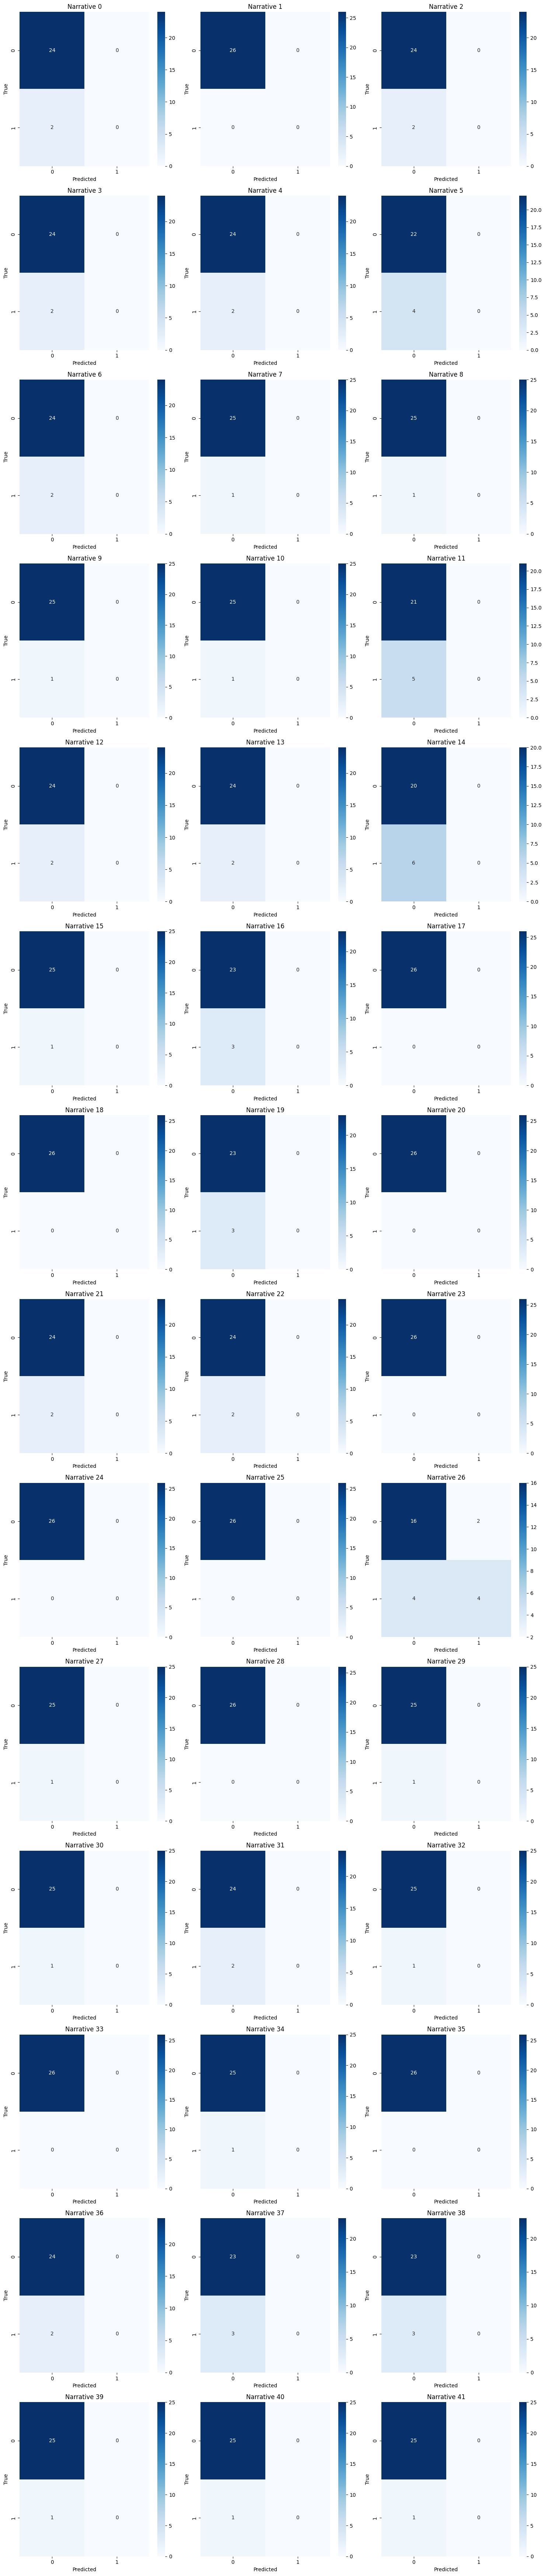

Climate Change Data:


,Narrative Index,Occurrences in Original DF,Occurrences in Train Set,Occurrences in Test Set,Occurrences in Predictions,Narrative
0,0,1,1,0,0,"{'narrative': 'Climate change is beneficial', 'subnarrative': 'Climate change is beneficial: CO2 is beneficial'}"
1,1,4,3,1,0,"{'narrative': 'Controversy about green technologies', 'subnarrative': 'Controversy about green technologies: Other'}"
2,2,2,2,0,0,"{'narrative': 'Controversy about green technologies', 'subnarrative': 'Controversy about green technologies: Renewable energy is costly'}"
3,3,1,1,0,0,"{'narrative': 'Controversy about green technologies', 'subnarrative': 'Controversy about green technologies: Renewable energy is dangerous'}"
4,4,2,2,0,0,"{'narrative': 'Controversy about green technologies', 'subnarrative': 'Controversy about green technologies: Renewable energy is unreliable'}"
5,5,8,6,2,0,"{'narrative': 'Criticism of climate movement', 'subnarrative': 'Criticism of climate movement: Ad hominem attacks on key activists'}"
6,6,5,5,0,0,"{'narrative': 'Criticism of climate movement', 'subnarrative': 'Criticism of climate movement: Climate movement is alarmist'}"
7,7,3,2,1,0,"{'narrative': 'Criticism of climate movement', 'subnarrative': 'Criticism of climate movement: Climate movement is corrupt'}"
8,8,2,2,0,0,"{'narrative': 'Criticism of climate movement', 'subnarrative': 'Criticism of climate movement: Other'}"
9,9,3,2,1,0,"{'narrative': 'Criticism of climate policies', 'subnarrative': 'Criticism of climate policies: Climate policies are ineffective'}"


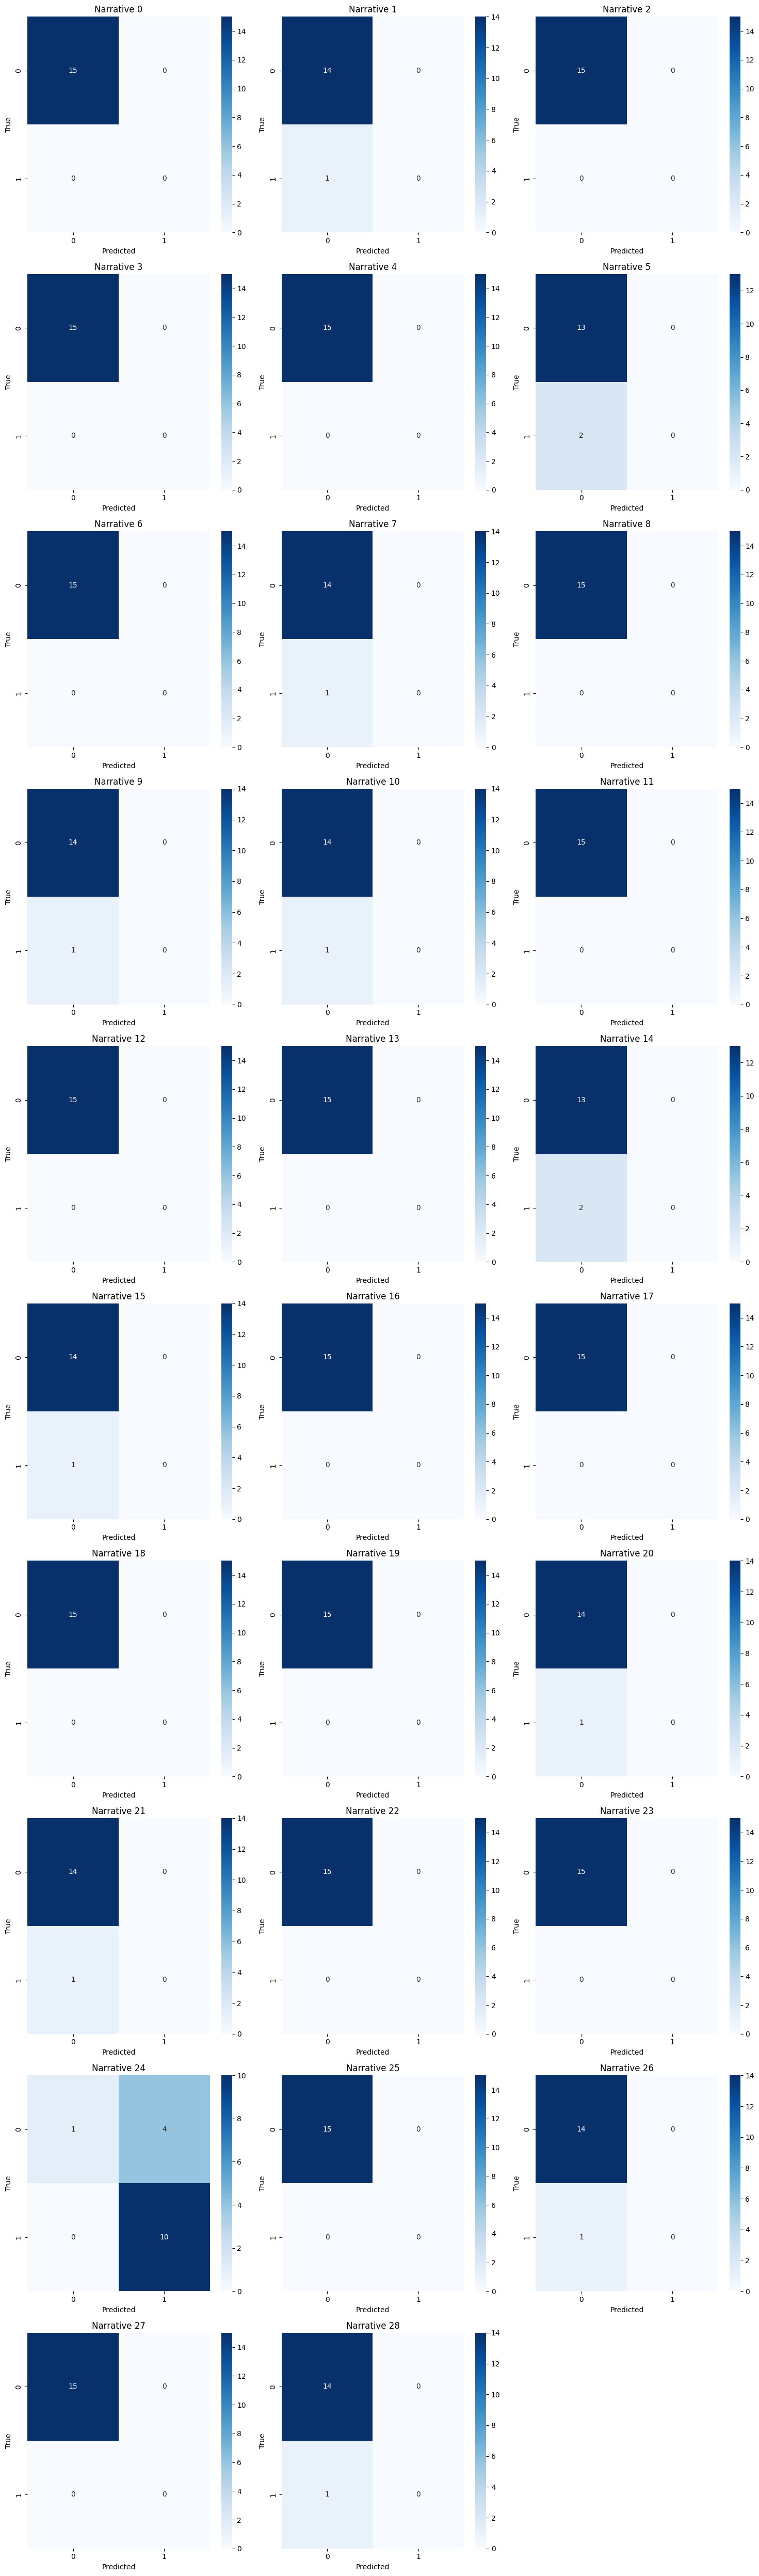

Complete Data:


,Narrative Index,Occurrences in Original DF,Occurrences in Train Set,Occurrences in Test Set,Occurrences in Predictions,Narrative
0,0,5,5,0,0,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'Amplifying war-related fears: By continuing the war we risk WWIII'}"
1,1,5,3,2,0,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'Amplifying war-related fears: NATO should/will directly intervene'}"
2,2,6,3,3,0,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'Amplifying war-related fears: Other'}"
3,3,11,9,2,0,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'Amplifying war-related fears: Russia will also attack other countries'}"
4,4,16,13,3,0,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'Amplifying war-related fears: There is a real possibility that nuclear weapons will be employed'}"
5,5,18,13,5,0,"{'narrative': 'Blaming the war on others rather than the invader', 'subnarrative': 'Blaming the war on others rather than the invader: The West are the aggressors'}"
6,6,3,2,1,0,"{'narrative': 'Blaming the war on others rather than the invader', 'subnarrative': 'Blaming the war on others rather than the invader: Ukraine is the aggressor'}"
7,7,1,1,0,0,"{'narrative': 'Climate change is beneficial', 'subnarrative': 'Climate change is beneficial: CO2 is beneficial'}"
8,8,4,4,0,0,"{'narrative': 'Controversy about green technologies', 'subnarrative': 'Controversy about green technologies: Other'}"
9,9,2,2,0,0,"{'narrative': 'Controversy about green technologies', 'subnarrative': 'Controversy about green technologies: Renewable energy is costly'}"


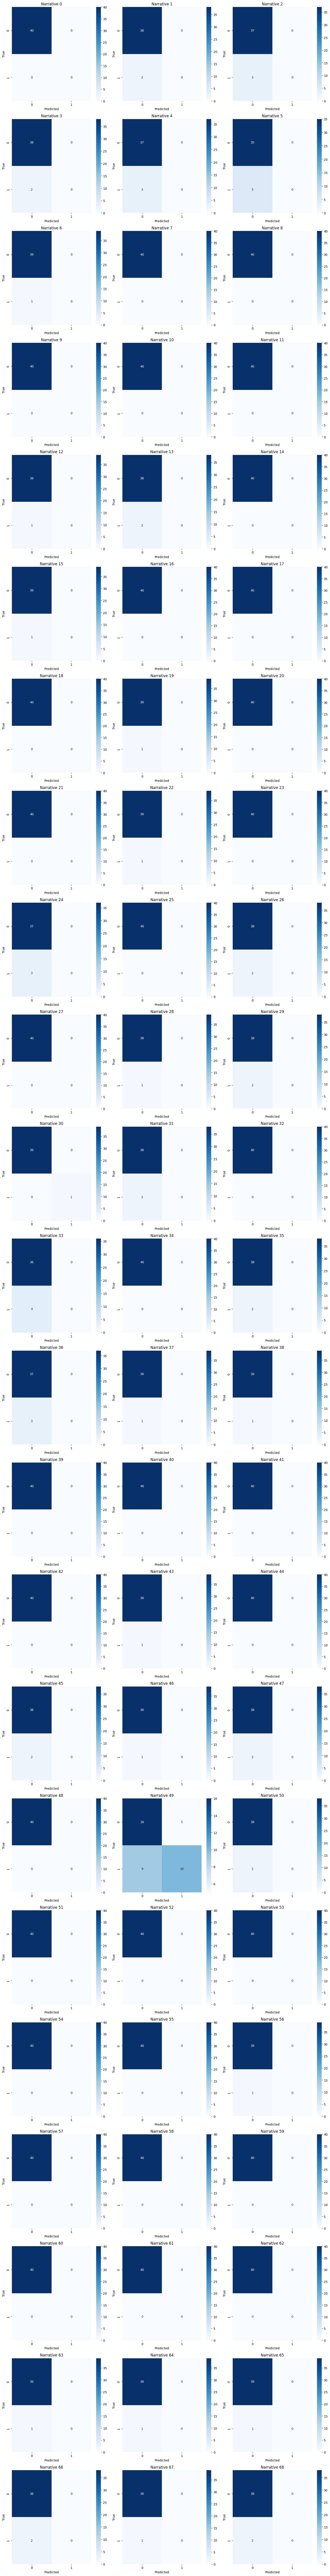

In [138]:
print("Ukraine War Data:")
show_class_occurrences(counts_df_ua)
show_confusion_matrix(conf_matr_ua)

print("Climate Change Data:")
show_class_occurrences(counts_df_cc)
show_confusion_matrix(conf_matr_cc)

print("Complete Data:")
show_class_occurrences(counts_df_compl)
show_confusion_matrix(conf_matr_compl)

## Result analysis

### Performance
**Precision and recall consideration**

- To evaluate performance, we look at the recall, precision and f1-score
- Generally, the SVM yields a higher precision than recall, indicating that the model is more accurate when predicting a narrative for an article, but it "misses" more narratives that actually apply to an article. We argue that a high recall is more relevant for this task.
- Given the example of assigning articles on X (formerly twitter)  to certain narratives to flag to it like "A problematic narrative x might be contained in this article", we are more interested in actually finding all relevant narratives.
- Therefore, if we optimise our results, we will do it with respect to recall

- possibly differentiate between classes (what to do depending how high prec/recall)

**Model performance**

- After considering precision vs. recall, we will focus on f1 score, which is a combination of the two, in the following as a single value for comparison.
- Generally, the resulting f1-score on the test set is quite low. If we look at the weighted average, it becomes slightly better since underrepresented classes, for which the model has almost no chance of learning them, are not weighted equally. This is due to multiple reasons:
    - task complexity with a large output space in terms of class number and multiple labels that can apply to an article
    - additionally, the class distribution is highly unbalanced
    - Lastly, with only using the english data, we have a quite limited dataset size, especially when considering the task complexity
    - lastly, the method of one-vs-rest classification with SVMs likely lacks the suitable capacity for this task

- When comparing training the classifier using the whole data as opposed to just the climate change data or the ukraine war data, we observe that the weighted average f1 score gets a little better. With the full data set, we have more data, however also a more complex classification problem. Therefore we would expect the performance to be equal. One explanation for the increased f1 score would be synergy effects, that occur when training on the combined dataset.

**Confusion Matrix and Occurence table**
- The computed scores seem to vary a lot amongst the individual labels. To take a closer look at the origins, we (1) list the number of occurences of each label in the original dataframe, the training set, the test set and the predictions and (2) print the confusion matrices (REFERENCE).
- The model solely predicts the narrative class 'Other'. There is a single prediction of another label for the combined training. 
- This is unexpected, since the scores indicated at least reasonable performance. 
- Taking a closer look, we see, that narrative class 'Other' is also the most represented class with only few others, that occur reasonably often in the dataset. Therefore it is able to **make up all the recall and precision score only from predicting the class 'Other'**.
- This highlights the challenge of the unbalanced dataset and the need for further data. We hope that with more data for the little represented classes, the model will also learn to consider them in its predictions.


### Task specific problems
**Class representation**

When training the SVM, a user warning occurs: "Label not :NUMBER: is present in all training examples". This is sklearns weird way of saying that there are label indices that do not occur in any of the training data instances. This happens the following way:
- The unique labels are generated using the whole dataset
- After making the train-test-split, it is likely that classes that have a low representation did not make it into the training set

The result of this is that the model obviously can't learn how to predict this class, resulting in no correct predictions for it. This is a problem specific problem, since in multi-class classification (xx classes), it frequently occurs that some classes are represented a lot and others very rarely.

Upon further analysis, we observe that there are classes that have very few occurances (even single occurances). This is a problem since it makes dealing with this problem challenging.
- Stratification at the train-test-split level could resolve this problem by ensuring the distribution of the classes is the same in train and test
    - With single occurances of classes, this is not possible since at least two occurances per class are necessary
- Using SMOTE to create synthetic training instances for underrepresented classes
    - For this as well, more than one occurance per class is necessary since the synthetic examples are generated using the "nearest neighbors" of that class
- Another way of dealing with the problem is to copy instances of classes that only occur once and then using stratification. Since that would lead to leakage from the training into the test data, this is worse than not addressing it since that way, the performance would be artificially raised.

Addressing this problem further will be a task for the final project submission.

